In [1]:
from dataloader import AssignmentData
from plot_drawer import Drawer
from linear_regression import SimpleLinearRegression, extended_linspace, Parameter
from pandas import Series
import numpy as np
%load_ext autoreload
%autoreload 2

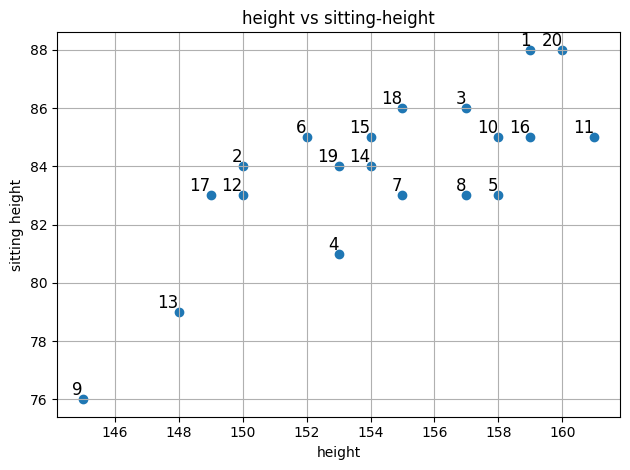

In [2]:
path = "./data/students_height_and_sitting_height.csv"
data = AssignmentData(path)
df = data.get_data()
df.columns = ["height", "sitting height"]

drawer = Drawer(df, fontsize=12)
drawer.plot_scatter_with_index("height vs sitting-height")

In [3]:
model = SimpleLinearRegression()
params = model.fit(df.iloc[:, 0], df.iloc[:, 1])
print(params)

傾き: 0.4756549170209848 / 切片: 10.382663557811


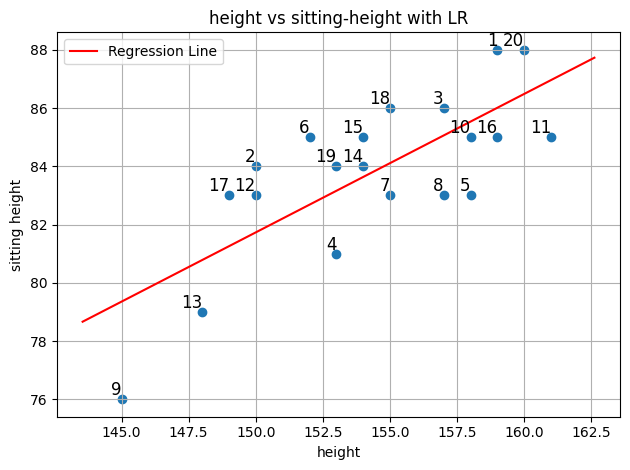

In [4]:
x = extended_linspace(df.iloc[:, 0], ratio=0.01)
drawer.plot_scatter_with_regression_line(
    x,
    model.predict(Series(x)),
    "height vs sitting-height with LR")

In [5]:
def sample_influence_function(p1: float, p2: float, n):
    return (n - 1) * (p1 - p2)

def compute_sif_values(p1: Parameter, p2: Parameter, n: int) -> list:
    return [
        sample_influence_function(p1.slope, p2.slope, n), 
        sample_influence_function(p1.intercept, p2.intercept, n)
    ]

def search_anomaly_data(data_x, data_y):
    sifs = []
    n = len(data_x)
    params1 = model.fit(data_x, data_y)
    for i in range(n):
        params2 = model.fit(
            drop_single_record(data_x, i),
            drop_single_record(data_y, i)
        )
        sifs.append(compute_sif_values(params1, params2, n))
    return np.array(sifs)

def drop_single_record(s: Series, i: int) -> Series:
    """ Returns copied Series """
    return s.drop(s.index[i])

In [6]:
data_x = df.iloc[:, 0]
data_y = df.iloc[:, 1]
sifs = search_anomaly_data(data_x, data_y)
sifs

array([[ 5.40985154e-01, -8.13804549e+01],
       [-5.72819252e-01,  9.08148959e+01],
       [ 1.39418077e-01, -2.05602206e+01],
       [ 1.60665484e-01, -2.69679991e+01],
       [-5.28172192e-01,  7.88857728e+01],
       [-3.03665732e-01,  4.92261534e+01],
       [-3.96019654e-02,  5.00203287e+00],
       [-3.05763178e-01,  4.50914151e+01],
       [ 2.30047934e+00, -3.59563691e+02],
       [-1.11655676e-01,  1.66764635e+01],
       [-8.21047143e-01,  1.24478155e+02],
       [-3.20375758e-01,  5.07924463e+01],
       [ 7.01659110e-01, -1.10315177e+02],
       [-7.03953443e-03,  1.45316104e+00],
       [-2.62480844e-02,  5.41835457e+00],
       [-2.75306808e-01,  4.14144327e+01],
       [-5.58244332e-01,  8.80669564e+01],
       [ 6.75099166e-02, -8.52702177e+00],
       [-6.27017145e-02,  1.05245989e+01],
       [ 5.16451057e-01, -7.80480947e+01]])

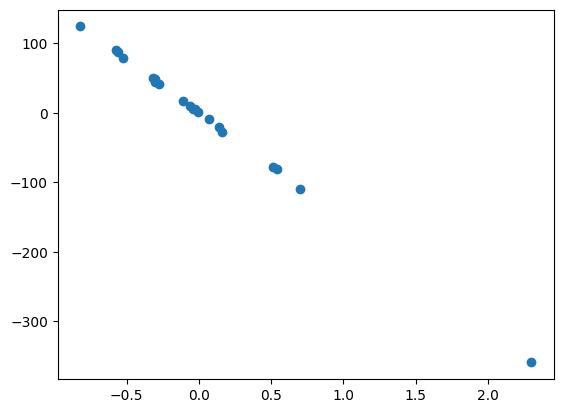

In [7]:
drawer.plot(sifs)

In [ ]:
def mahalanobis_distances(x: np.ndarray) -> np.ndarray:
    mean = np.mean(x, axis=0)
    inv_cov = np.linalg.inv(np.cov(x.T))
    return [np.dot(np.dot((s-mean), inv_cov), (s-mean).T) for s in x]

In [ ]:
from scipy.spatial import distance
from pandas import DataFrame

def mahalanobis_distances(x: np.ndarray) -> np.ndarray:
    mean = np.mean(x, axis=0)
    cov = np.cov(x, rowvar=False)
    cov_inv = np.linalg.inv(cov)

    dists = [distance.mahalanobis(row, mean, cov_inv) for row in x]
    return np.array(dists)

In [9]:
np.sqrt(mahalanobis_distances(df.values))

[154.35  83.8 ]


array([1.22980259, 1.2571488 , 0.88918696, 1.09959451, 1.26769034,
       1.16859554, 0.78677821, 1.12685003, 1.67417782, 0.93939489,
       1.36150351, 1.09904898, 1.31949094, 0.46264308, 0.86294904,
       1.09305552, 1.24277397, 1.01743415, 0.74203681, 1.23620346])

In [10]:
from scipy.stats import chi2
alpha = 0.01
chi2.ppf(1 - alpha, df=2)

np.float64(9.21034037197618)